In [ ]:
from google.colab import files
uploaded =files.upload()

Saving heart_2020_cleaned.csv to heart_2020_cleaned.csv


In [ ]:
%pip install imblearn
%pip install category_encoders

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from category_encoders import OneHotEncoder
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix

In [ ]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [ ]:
df.shape


(319792, 18)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319792 entries, 0 to 319791
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319792 non-null  object 
 1   BMI               313011 non-null  float64
 2   Smoking           313011 non-null  object 
 3   AlcoholDrinking   313011 non-null  object 
 4   Stroke            313011 non-null  object 
 5   PhysicalHealth    313011 non-null  float64
 6   MentalHealth      313011 non-null  float64
 7   DiffWalking       313011 non-null  object 
 8   Sex               313011 non-null  object 
 9   AgeCategory       313011 non-null  object 
 10  Race              313011 non-null  object 
 11  Diabetic          313011 non-null  object 
 12  PhysicalActivity  313011 non-null  object 
 13  GenHealth         313011 non-null  object 
 14  SleepTime         313011 non-null  float64
 15  Asthma            313011 non-null  object 
 16  KidneyDisease     31

In [ ]:
df.duplicated().sum()


np.int64(18078)

In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df.shape


(301714, 18)

In [ ]:
df.isna().sum()


,0
HeartDisease,0
BMI,6776
Smoking,6776
AlcoholDrinking,6776
Stroke,6776
PhysicalHealth,6776
MentalHealth,6776
DiffWalking,6776
Sex,6776
AgeCategory,6776


In [ ]:
df.describe()


,BMI,PhysicalHealth,MentalHealth,SleepTime
count,294938.000000,294938.000000,294938.000000,294938.000000
mean,28.395780,3.550177,4.112769,7.085855
std,6.448634,8.114006,8.110902,1.465760
min,12.020000,0.000000,0.000000,1.000000
25%,23.960000,0.000000,0.000000,6.000000
50%,27.370000,0.000000,0.000000,7.000000
75%,31.620000,2.000000,4.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


In [ ]:
count_target = df['HeartDisease'].value_counts()
count_target

,count
HeartDisease,
No,268466
Yes,26472
"No,30.41,Yes,No,No,0.0,0.0,No,Female,70-74,White,""No, borderline diabetes"",Yes,Very good,7.0,No,No,No",1
"No,23.82,No,No,No,0.0,0.0,No,Male,30-34,White,""No, borderline diabetes"",Yes,Very good,7.0,No,No,No",1
"No,29.99,No,No,No,1.0,3.0,No,Male,55-59,White,""No, borderline diabetes"",Yes,Fair,7.0,No,No,No",1
...,...
"No,22.24,No,No,No,0.0,0.0,No,Male,65-69,White,""No, borderline diabetes"",Yes,Excellent,9.0,No,No,No",1
"No,48.06,No,No,No,1.0,1.0,No,Female,65-69,White,""No, borderline diabetes"",No,Very good,8.0,No,No,No",1
"Yes,20.6,Yes,No,No,0.0,5.0,No,Female,55-59,White,""No, borderline diabetes"",Yes,Fair,7.0,No,No,No",1


In [ ]:
df['PhysicalHealth'].unique()

array([ 3.,  0., 20., 28.,  6., 15.,  5., nan, 30.,  7.,  1.,  2., 21.,
        4., 10., 14., 18., 25., 16., 29., 27.,  8., 24., 12., 23., 26.,
       22.,  9., 13., 17., 11., 19.])

In [ ]:
df['MentalHealth'].unique()


array([30.,  0., nan,  2.,  5., 15.,  8.,  4.,  3., 10., 14., 20.,  1.,
       24.,  9., 28., 16., 12.,  7.,  6., 25., 17., 21., 29., 18., 22.,
       13., 23., 27., 26., 11., 19.])

In [ ]:
df['BMI'].unique()


array([16.6 , 20.34, 26.58, ..., 62.42, 51.46, 46.56])

In [ ]:
def remove_outliers_from_dataframe(df):

    for column in df.columns:
        if column in ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [ ]:
df=remove_outliers_from_dataframe(df)


In [ ]:
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']

In [ ]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)


In [ ]:
df[['BMI', 'BMI_Category']].head(10)


,BMI,BMI_Category
1,20.34,Normal weight
3,24.21,Normal weight
7,31.64,Obesity I
9,40.69,Obesity III
11,28.71,Overweight
12,28.37,Overweight
15,29.18,Overweight
16,26.26,Overweight
18,29.86,Overweight
19,18.13,Underweight


In [ ]:
df['BMI_Category'].value_counts()


,count
BMI_Category,
Overweight,78136
Normal weight,65240
Obesity I,41704
Obesity II,16503
Obesity III,4563
Underweight,3235


In [ ]:
df['Diabetic'].value_counts()


,count
Diabetic,
No,183361
Yes,24319
Yes (during pregnancy),1701


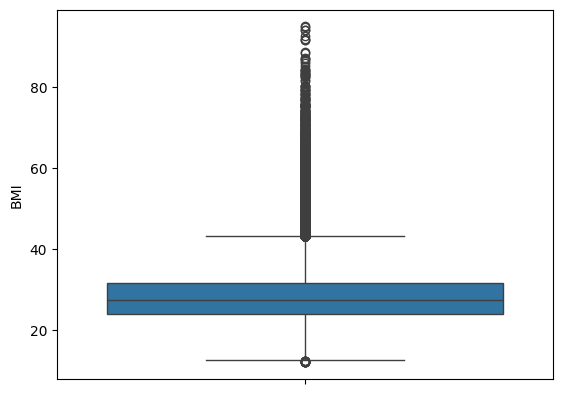

In [ ]:
sns.boxplot(df['BMI'])
plt.show()

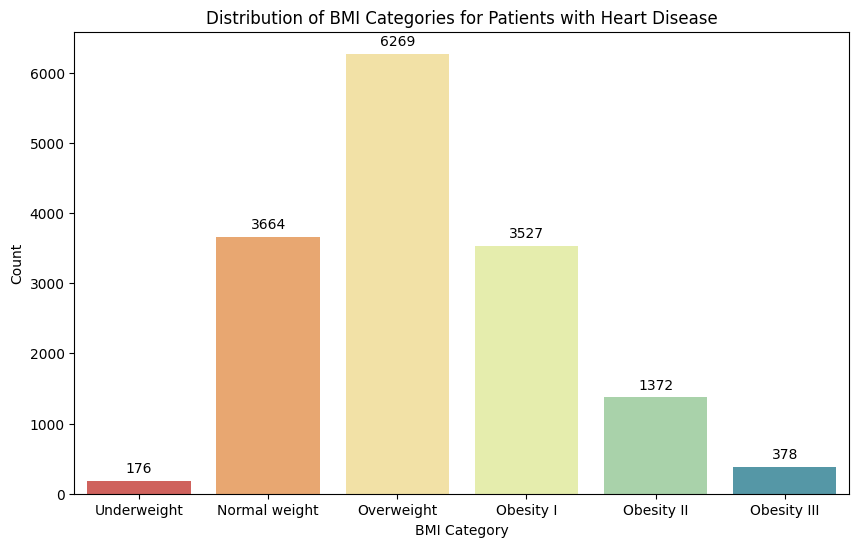

In [ ]:
df_heart_disease = df[df['HeartDisease'] == 'Yes']

plt.figure(figsize=(10,6))
ax = sns.countplot(x='BMI_Category', data=df_heart_disease, palette='Spectral')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Distribution of BMI Categories for Patients with Heart Disease')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()

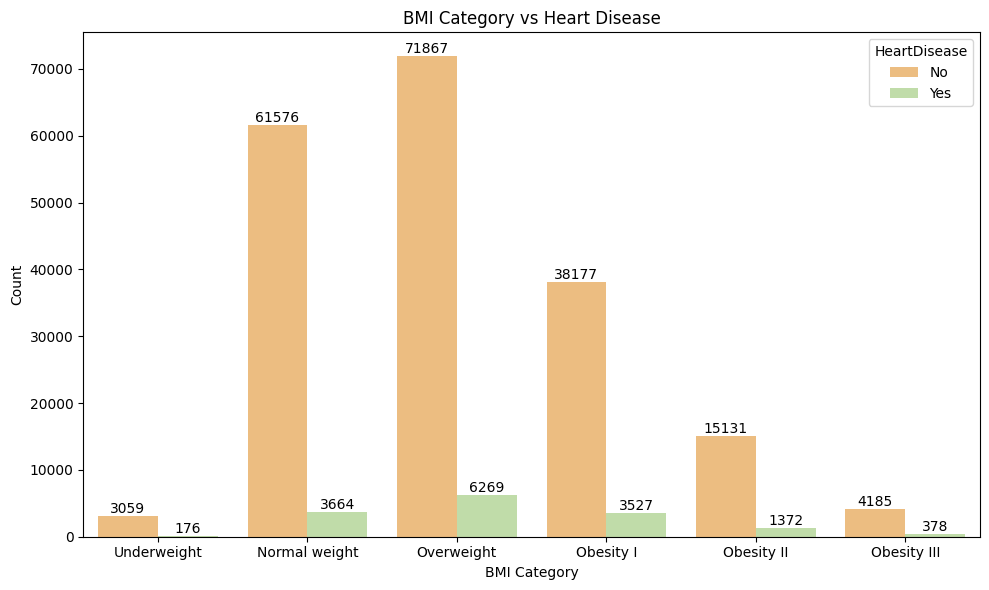

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='BMI_Category', hue='HeartDisease', data=df, palette='Spectral')

plt.title('BMI Category vs Heart Disease')
plt.xlabel('BMI Category')
plt.ylabel('Count')

# Optional: annotate bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


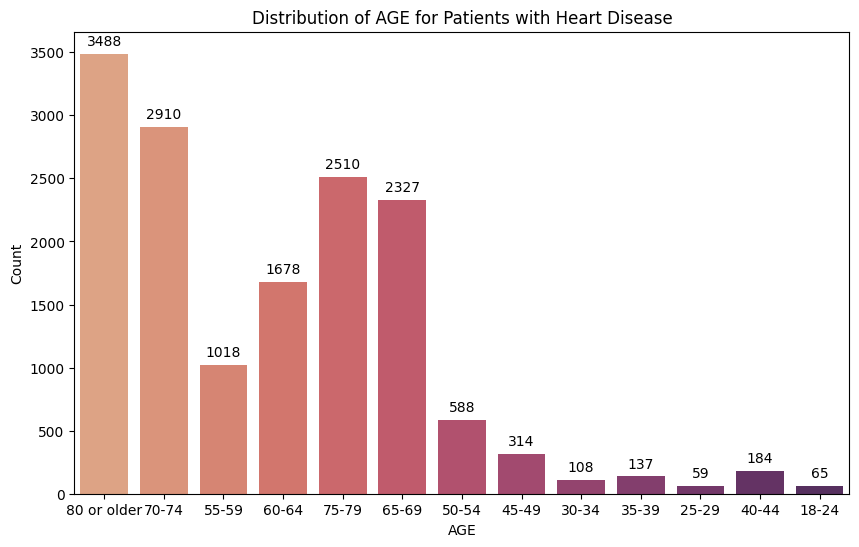

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='AgeCategory', data=df_heart_disease, palette='flare')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Distribution of AGE for Patients with Heart Disease')
plt.xlabel('AGE')
plt.ylabel('Count')
plt.show()

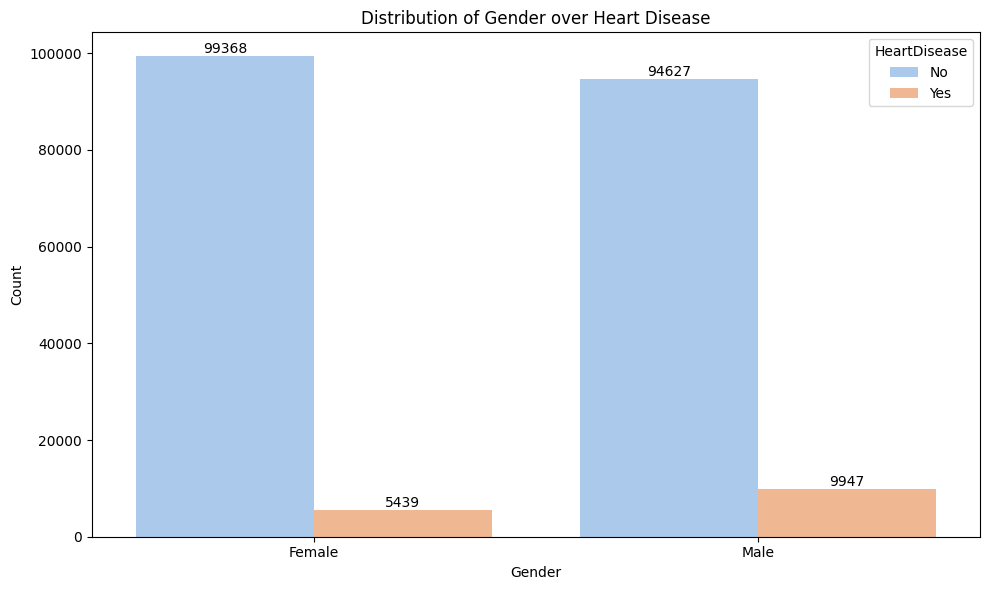

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Sex', hue='HeartDisease', data=df, palette='pastel', dodge=True)

plt.title('Distribution of Gender over Heart Disease')
plt.xlabel('Gender')
plt.ylabel('Count')

# Optional: Add counts on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


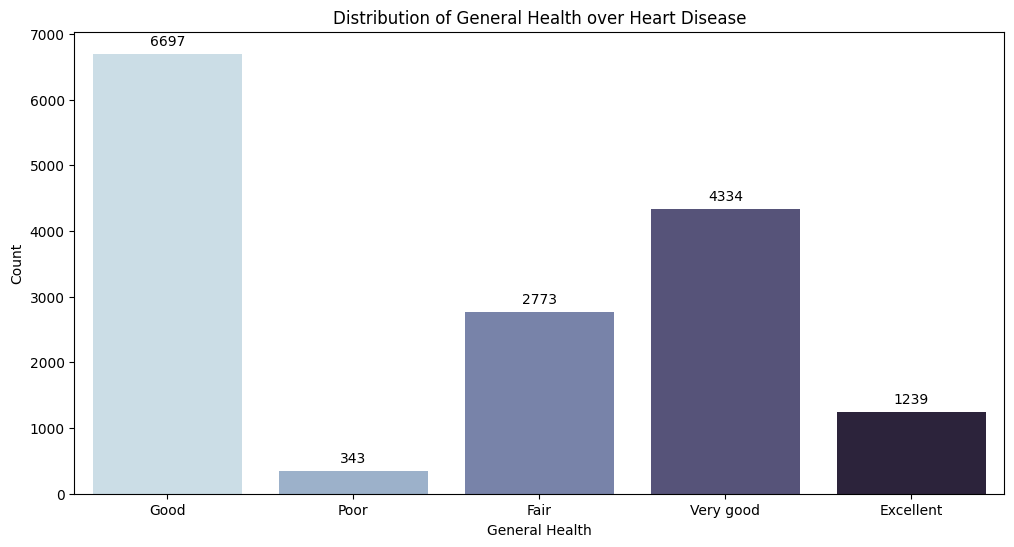

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='GenHealth', data=df_heart_disease, palette='ch:s=.25,rot=-.25')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')
plt.title('Distribution of General Health over Heart Disease')
plt.xlabel('General Health')
plt.ylabel('Count')
plt.show()

In [ ]:
df['Diabetic'] = df['Diabetic'].replace({
    'No, borderline diabetes': 'No',
    'Yes (during pregnancy)': 'Yes'
})

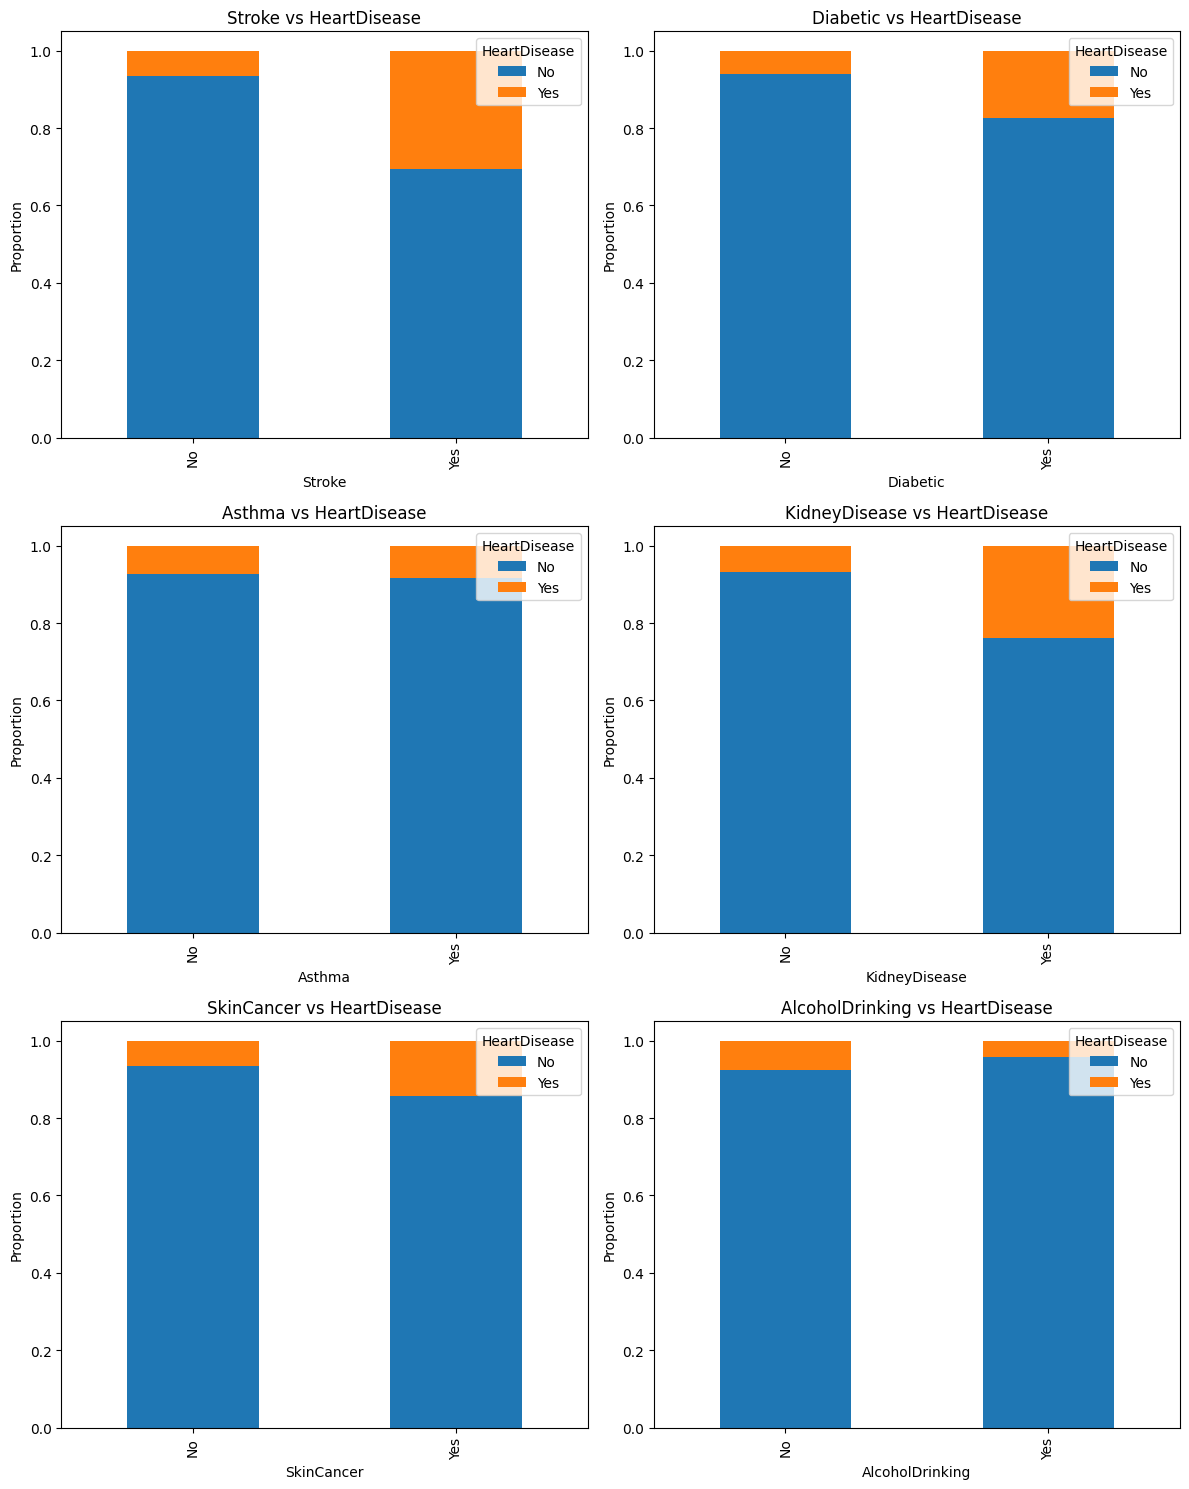

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def stacked_bar(data, feature, target, ax):
    crosstab = pd.crosstab(data[feature], data[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, ax=ax, width=0.5)  # narrower bars for closer spacing
    ax.set_title(f'{feature} vs {target}')
    ax.set_ylabel('Proportion')
    ax.set_xlabel(feature)
    ax.legend(title=target, loc='upper right')  # optional: place legend nicely

# Set up the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Features to plot
features = ['Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer', 'AlcoholDrinking']

# Generate plots
for i, feature in enumerate(features):
    stacked_bar(df, feature, 'HeartDisease', axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


<Axes: xlabel='MentalHealth', ylabel='Density'>

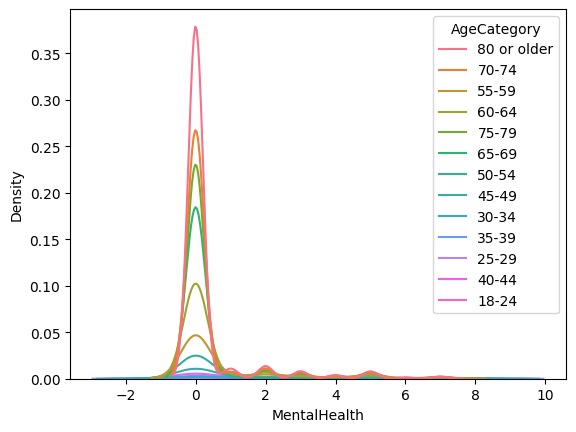

In [ ]:
#MentalHealth
sns.kdeplot(data=df[df['HeartDisease']=='Yes'],x='MentalHealth',hue='AgeCategory')

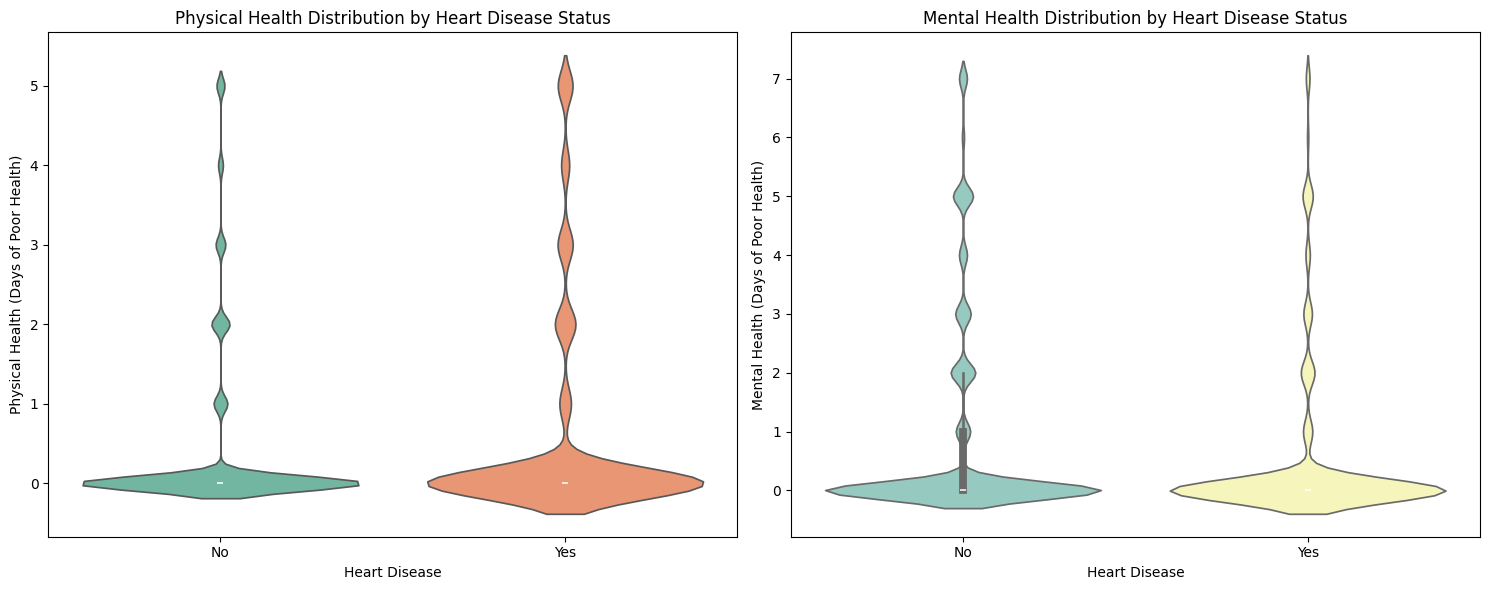

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='HeartDisease', y='PhysicalHealth', data=df, palette='Set2')
plt.title('Physical Health Distribution by Heart Disease Status')
plt.xlabel('Heart Disease')
plt.ylabel('Physical Health (Days of Poor Health)')


plt.subplot(1, 2, 2)
sns.violinplot(x='HeartDisease', y='MentalHealth', data=df, palette='Set3')
plt.title('Mental Health Distribution by Heart Disease Status')
plt.xlabel('Heart Disease')
plt.ylabel('Mental Health (Days of Poor Health)')


plt.tight_layout()
plt.show()

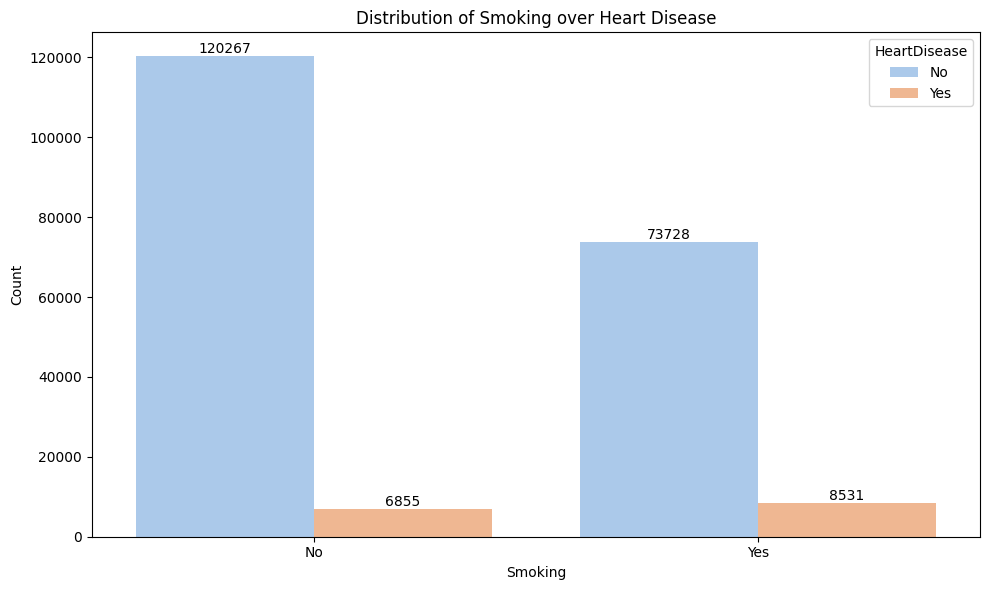

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Smoking', hue='HeartDisease', data=df, palette='pastel')

plt.title('Distribution of Smoking over Heart Disease')
plt.xlabel('Smoking')
plt.ylabel('Count')

# Annotate bar heights
for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(
            f'{int(height)}',                        # Label text
            (p.get_x() + p.get_width() / 2., height),# Position
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.show()


In [ ]:
df.corr(numeric_only=True)

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.035316,-0.026406,-0.053845
PhysicalHealth,0.035316,1.000000,0.123321,-0.026943
MentalHealth,-0.026406,0.123321,1.000000,-0.053250
SleepTime,-0.053845,-0.026943,-0.053250,1.000000


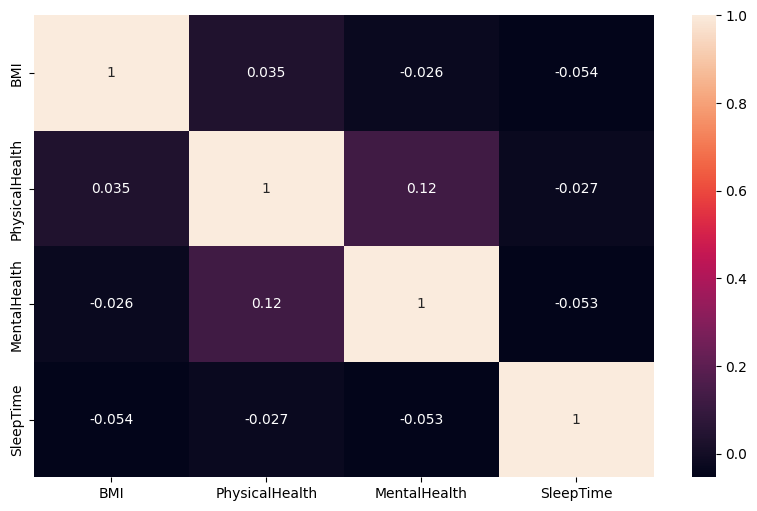

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

ordinal_cols = ['BMI_Category', 'AgeCategory', 'Race', 'GenHealth']
boolean_cols = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

ordinal_mappings = {
    'BMI_Category': ['Underweight', 'Normal weight', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'],
    'AgeCategory': ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'],
    'Race': ['White', 'Black', 'Asian','Hispanic', 'American Indian/Alaskan Native', 'Other'],
    'GenHealth': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
}

df['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1})
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_cols]), ordinal_cols),  # Ordinal encoding
        ('ohe', OneHotEncoder(drop='first'), boolean_cols)  # OneHotEncoding for boolean columns
    ],
    remainder='passthrough'
)


df_transformed = preprocessor.fit_transform(df)

# Convert the transformed data back to a DataFrame with appropriate column names
# Ordinal columns retain original names, while OneHotEncoder generates new columns
ohe_columns = preprocessor.named_transformers_['ohe'].get_feature_names_out(boolean_cols)
final_columns = ordinal_cols + list(ohe_columns) + [col for col in df.columns if col not in ordinal_cols + boolean_cols]

df_encoded = pd.DataFrame(df_transformed, columns=final_columns)

In [ ]:
df_encoded.head()


,BMI_Category,AgeCategory,Race,GenHealth,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Diabetic_Yes,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,BMI,PhysicalHealth,MentalHealth,Sex,SleepTime
0,1.0,12.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,20.34,0.0,0.0,0.0,7.0
1,1.0,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,24.21,0.0,0.0,0.0,6.0
2,3.0,12.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,31.64,5.0,0.0,0.0,9.0
3,5.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,40.69,0.0,0.0,1.0,10.0
4,2.0,7.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.71,0.0,0.0,0.0,5.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
X = df_encoded.drop(['HeartDisease_Yes', 'Race'], axis=1)
y = df_encoded['HeartDisease_Yes']

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_scaled= scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Display the results
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Heart Disease', 'Heart Disease'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return accuracy

In [ ]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)

X_train_resampled, y_train_resampled = under.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_resampled, y_train_resampled)
Counter(y_train_resampled)

Counter({0.0: 123620, 1.0: 123620})

In [ ]:
def train(classifier,x_train,y_train,x_test,y_test):

    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))


def model_evaluation(classifier,x_test,y_test):

    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')

    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [ ]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.9278


In [ ]:
rf_classifier = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=10, random_state=42)
)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

Random Forest Classifier Accuracy: 0.88
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     38853
         1.0       0.20      0.20      0.20      3024

    accuracy                           0.88     41877
   macro avg       0.57      0.57      0.57     41877
weighted avg       0.88      0.88      0.88     41877



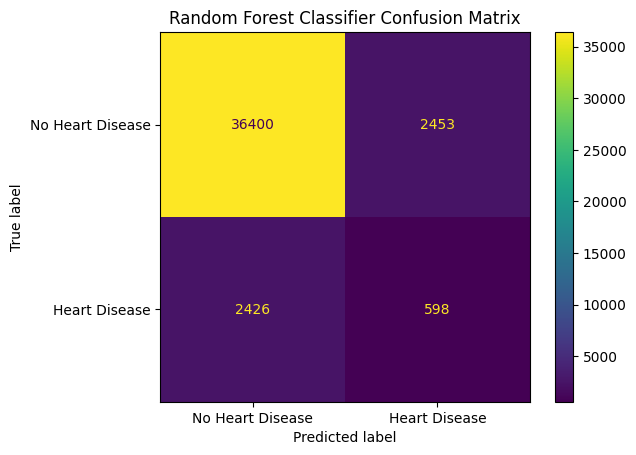

0.883492131719082

In [ ]:
rf_accuracy= evaluate_model(rf, X_test, y_test, 'Random Forest Classifier')
rf_accuracy

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier()

Gradient Boosting Classifier Accuracy: 0.86
Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     38853
         1.0       0.25      0.47      0.33      3024

    accuracy                           0.86     41877
   macro avg       0.60      0.68      0.62     41877
weighted avg       0.90      0.86      0.88     41877



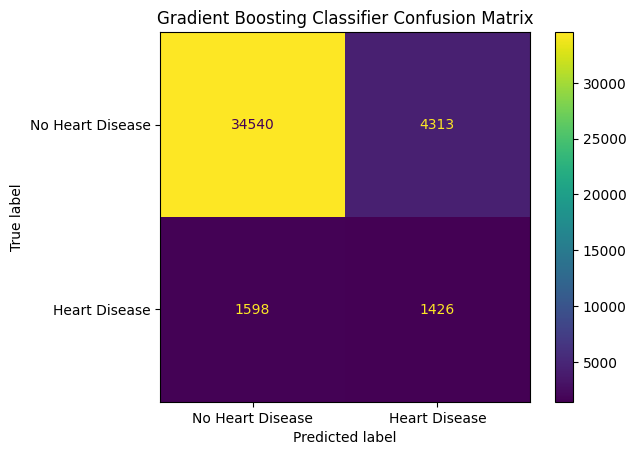

0.8588485326073979

In [ ]:
gbc_accuracy = evaluate_model(gbc, X_test, y_test, 'Gradient Boosting Classifier')
gbc_accuracy

In [ ]:
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgboost_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

XGBoost Classifier Accuracy: 0.90
XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     38853
         1.0       0.27      0.26      0.26      3024

    accuracy                           0.90     41877
   macro avg       0.61      0.60      0.60     41877
weighted avg       0.89      0.90      0.89     41877



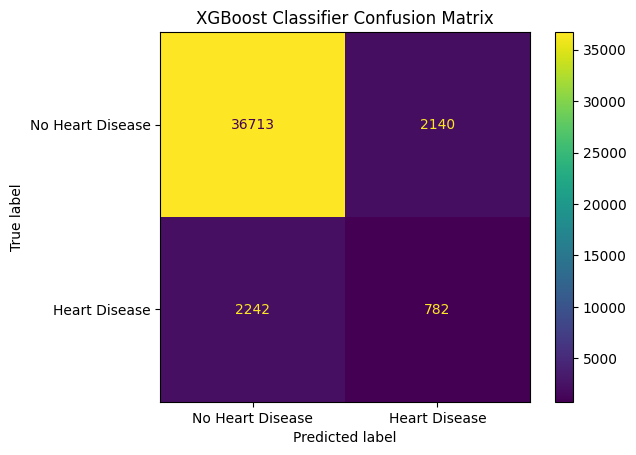

XGBoost Classifier Accuracy: 0.8953602216013563


In [ ]:
xgboost_accuracy = evaluate_model(xgboost_model, X_test, y_test, 'XGBoost Classifier')
print(f'XGBoost Classifier Accuracy: {xgboost_accuracy}')

In [ ]:
import lightgbm as lgb

lgbm_params = {
    'subsample': 0.95,
    'reg_lambda': 0.005623413251903491,
    'reg_alpha': 1.0,
    'num_leaves': 570,
    'n_estimators': 550,
    'min_data_in_leaf': 135,
    'min_child_weight': 0.02,
    'max_depth': 13,
    'learning_rate': 0.015,
    'feature_fraction': 0.85,
    'colsample_bytree': 0.9,
    'cat_smooth': 50,
    'bagging_freq': 9,
    'bagging_fraction': 0.85
}

lightgbm_model = lgb.LGBMClassifier(**lgbm_params, random_state=42, verbose=-1)
lightgbm_model.fit(X_train_resampled, y_train_resampled)

LGBMClassifier(bagging_fraction=0.85, bagging_freq=9, cat_smooth=50,
               colsample_bytree=0.9, feature_fraction=0.85, learning_rate=0.015,
               max_depth=13, min_child_weight=0.02, min_data_in_leaf=135,
               n_estimators=550, num_leaves=570, random_state=42, reg_alpha=1.0,
               reg_lambda=0.005623413251903491, subsample=0.95, verbose=-1)

LightGBM Classifier Accuracy: 0.90
LightGBM Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     38853
         1.0       0.27      0.26      0.27      3024

    accuracy                           0.90     41877
   macro avg       0.61      0.60      0.61     41877
weighted avg       0.89      0.90      0.90     41877



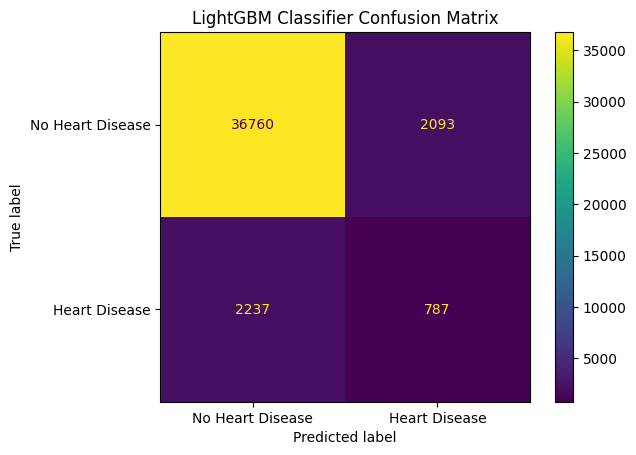

LightGBM Classifier Accuracy: 0.896601953339542


In [ ]:
lightgbm_accuracy = evaluate_model(lightgbm_model, X_test, y_test, 'LightGBM Classifier')
print(f'LightGBM Classifier Accuracy: {lightgbm_accuracy}')

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

Logistic Regression Accuracy: 0.73
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.83     38853
         1.0       0.18      0.78      0.30      3024

    accuracy                           0.73     41877
   macro avg       0.58      0.75      0.56     41877
weighted avg       0.92      0.73      0.79     41877



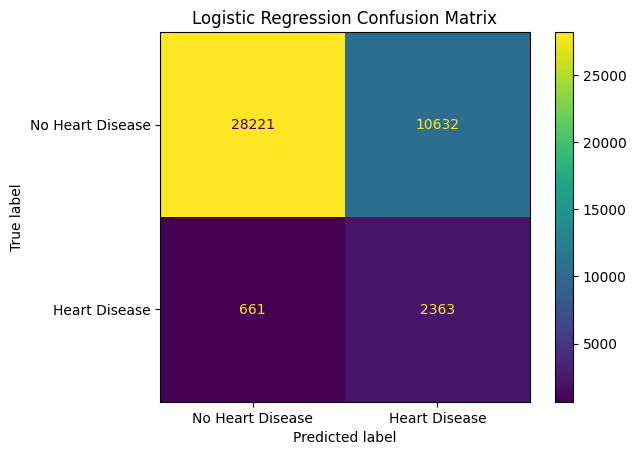

0.7303292977051842

In [ ]:
log_reg_accuracy =evaluate_model(log_reg, X_test, y_test, 'Logistic Regression')
log_reg_accuracy

In [ ]:
algorithms = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost Classifier','LightGBM Classifier']
accuracies = [log_reg_accuracy,rf_accuracy, gbc_accuracy,xgboost_accuracy,lightgbm_accuracy ]

results_df = pd.DataFrame({'Algorithms': algorithms, 'Accuracies': accuracies})


results_df

,Algorithms,Accuracies
0,Logistic Regression,0.730329
1,Random Forest,0.883492
2,Gradient Boosting,0.858849
3,XGBoost Classifier,0.895360
4,LightGBM Classifier,0.896602


In [ ]:
df.shape

(209381, 19)

In [ ]:
%pip install xgboost imbalanced-learn scikit-learn


✅ Best threshold for F1: 0.8123

📊 Confusion Matrix:
 [[33564  5236]
 [ 1554  1523]]

📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91     38800
         1.0       0.23      0.49      0.31      3077

    accuracy                           0.84     41877
   macro avg       0.59      0.68      0.61     41877
weighted avg       0.90      0.84      0.86     41877

🔹 ROC-AUC Score: 0.8001887005015597


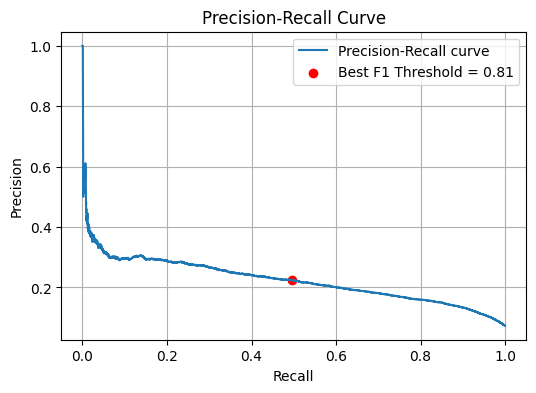

In [ ]:
def train_heart_disease_model(df, target_col="HeartDisease"):
    # Step 1: Split features and target
    X = df_encoded.drop(['HeartDisease_Yes', 'Race'], axis=1)
    y = df_encoded['HeartDisease_Yes']

    # Step 2: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Apply SMOTE to training data
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    # Step 4: Compute scale_pos_weight
    scale = (y_train == 0).sum() / (y_train == 1).sum()

    # Step 5: Train XGBoost model
    model = XGBClassifier(
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_resampled, y_resampled)

    # Step 6: Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # Step 7: Find best threshold via F1-score
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"✅ Best threshold for F1: {best_threshold:.4f}")

    # Step 8: Predict using best threshold
    y_pred = (y_proba >= best_threshold).astype(int)

    # Step 9: Evaluate performance
    print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
    print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Step 10: Plot Precision-Recall curve (optional)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label="Precision-Recall curve")
    plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red',
                label=f"Best F1 Threshold = {best_threshold:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return model, best_threshold

model, threshold = train_heart_disease_model(df)


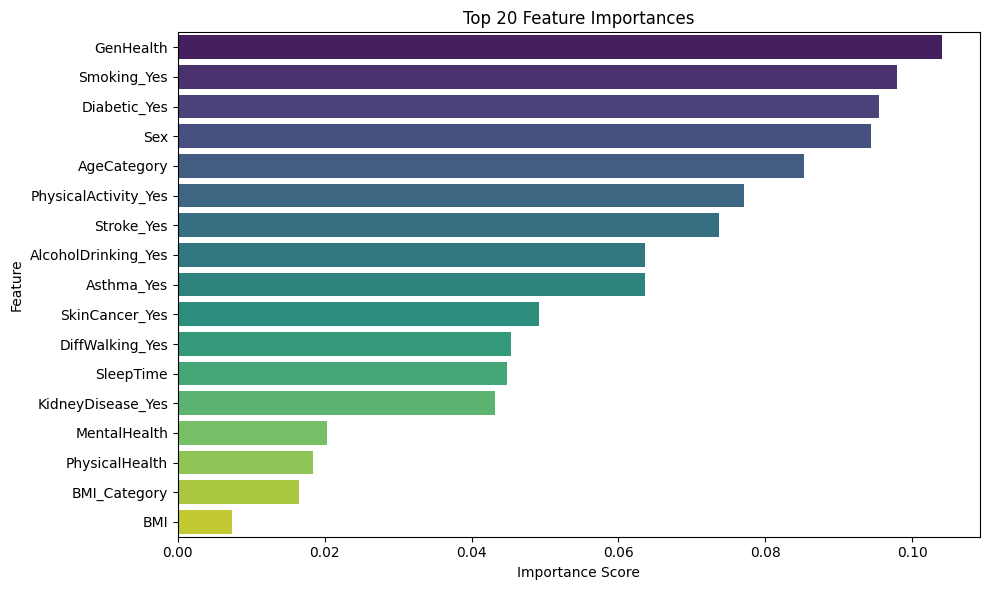

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = feat_importances.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
import pickle

# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)